<h1>Лабораторная работа 2</h1>
Енгоян Сергей и Ключковский Даниил А-01м-25<br>
Предварительная обработка речевой информации

<h4>Пункт 2 - Загрузка речевой информации и выявление участков голосовой активности

In [79]:
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

In [80]:
def load_audio_soundfile(filename):
    """
    Загрузка аудиофайла с помощью библиотеки soundfile
    """
    audio_data, sample_rate = sf.read(filename)

    # Если сигнал стерео — усредняем каналы (получаем моно)
    if audio_data.ndim > 1:
        audio_data = np.mean(audio_data, axis=1)

    # Нормализация: приведение амплитуды к диапазону [-1, 1]
    max_val = np.max(np.abs(audio_data))
    if max_val > 1:
        audio_data = audio_data / max_val

    return audio_data.astype(np.float32), sample_rate

In [81]:
def plot_audio_signal(audio_signal, sample_rate, title="Речевой сигнал"):
    """
    Построение графика речевого сигнала
    """
    time_axis = np.arange(len(audio_signal)) / sample_rate

    plt.figure(figsize=(12, 4))
    plt.plot(time_axis, audio_signal, linewidth=1)
    plt.title(title)
    plt.xlabel('Время (секунды)')
    plt.ylabel('Амплитуда')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Информация о файле:
SOUNDS/record_out.wav
samplerate: 48000 Hz
channels: 1
duration: 20.280 s
format: WAV (Microsoft) [WAV]
subtype: Signed 16 bit PCM [PCM_16]

Базовая информация:
 - Частота дискретизации: 48000 Гц
 - Количество сэмплов: 973440
 - Длительность: 20.28 секунд
 - Диапазон значений: [-0.551, 0.222]


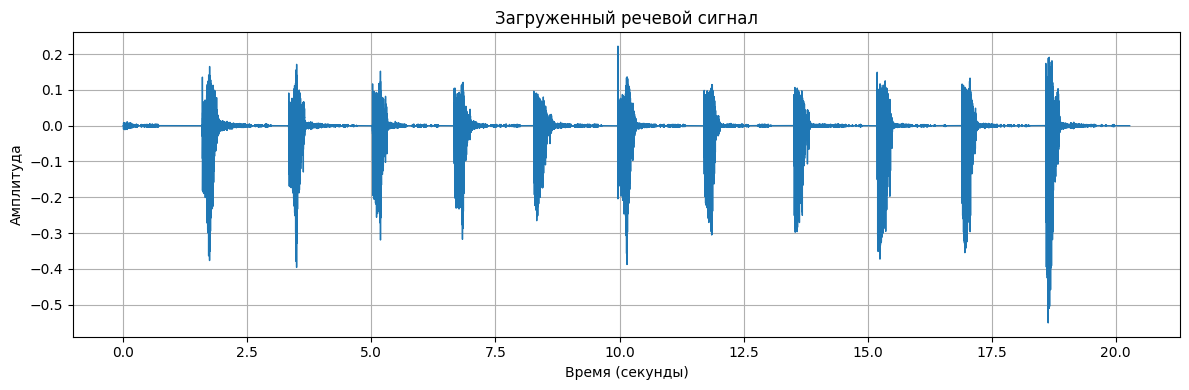

In [82]:
filename = "SOUNDS/record_out.wav"
# Информация о файле
print("Информация о файле:")
print(sf.info(filename))
print()
audio_signal, fs = load_audio_soundfile(filename)

# Вывод базовой информации
print("Базовая информация:")
print(f" - Частота дискретизации: {fs} Гц")
print(f" - Количество сэмплов: {len(audio_signal)}")
print(f" - Длительность: {len(audio_signal)/fs:.2f} секунд")
print(f" - Диапазон значений: [{np.min(audio_signal):.3f}, {np.max(audio_signal):.3f}]")

# Визуализация
plot_audio_signal(audio_signal, fs, "Загруженный речевой сигнал")

In [83]:
def frame_signal(signal, frame_size, overlap):
    """
    Разбиение сигнала на кадры с заданным перекрытием
    frame_size — размер кадра в сэмплах
    overlap — доля перекрытия (например, 0.5 = 50%)
    """
    step = int(frame_size * (1 - overlap))
    frames = []
    for start in range(0, len(signal) - frame_size, step):
        frame = signal[start:start + frame_size]
        frames.append(frame)
    return np.array(frames)

In [84]:
def short_time_energy(frames):
    """Расчёт кратковременной энергии для каждого кадра"""
    energy = np.array([np.sum(frame ** 2) / len(frame) for frame in frames])
    return energy

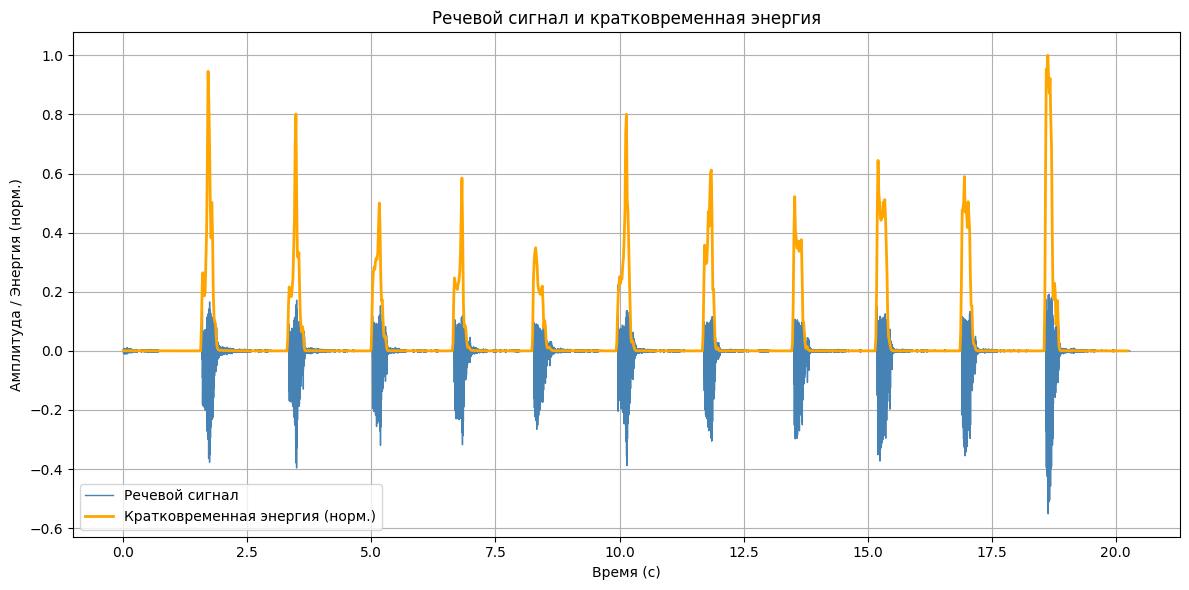

In [85]:
frame_duration = 0.03  # 30 мс
overlap = 0.5          # 50%
frame_size = int(frame_duration * fs)

frames = frame_signal(audio_signal, frame_size, overlap)

# --- Кратковременная энергия ---
energy = short_time_energy(frames)
time_axis_signal = np.arange(len(audio_signal)) / fs
time_axis_energy = np.arange(len(energy)) * frame_duration * (1 - overlap)

# --- График сигнала и энергии ---
plt.figure(figsize=(12, 6))

# Сигнал
plt.plot(time_axis_signal, audio_signal, label="Речевой сигнал", color='steelblue', linewidth=1)

# Энергия (нормализуем, чтобы она не перекрывала сигнал)
energy_norm = energy / np.max(energy)
plt.plot(time_axis_energy, energy_norm, label="Кратковременная энергия (норм.)", color='orange', linewidth=2)

plt.title("Речевой сигнал и кратковременная энергия")
plt.xlabel("Время (с)")
plt.ylabel("Амплитуда / Энергия (норм.)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [86]:
def detect_voice_activity(energy, threshold):
    """Возвращает список участков, где энергия превышает порог"""
    active = energy > threshold
    segments = []
    start = None

    for i, val in enumerate(active):
        if val and start is None:
            start = i
        elif not val and start is not None:
            segments.append((start, i))
            start = None
    if start is not None:
        segments.append((start, len(active)))

    return segments

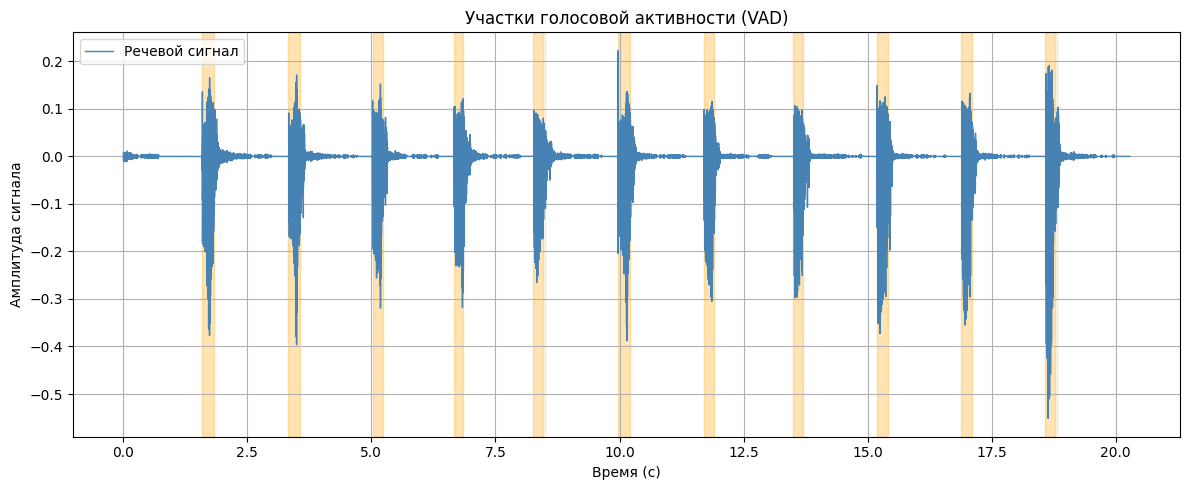

In [87]:
threshold = 0.1 * np.max(energy)
segments = detect_voice_activity(energy, threshold)

time_axis_signal = np.arange(len(audio_signal)) / fs
time_axis_energy = np.arange(len(energy)) * frame_duration * (1 - overlap)
energy_norm = energy / np.max(energy)

plt.figure(figsize=(12, 5))

# Сам речевой сигнал
plt.plot(time_axis_signal, audio_signal, label="Речевой сигнал", color='steelblue', linewidth=1)

# Отмечаем участки голосовой активности
for start, end in segments:
    x_start = time_axis_energy[start]
    x_end = time_axis_energy[end-1]
    plt.axvspan(x_start, x_end, color='orange', alpha=0.3)

plt.title("Участки голосовой активности (VAD)")
plt.xlabel("Время (с)")
plt.ylabel("Амплитуда сигнала")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [88]:
def remove_silence_and_save(filename, output_filename, frame_duration, overlap):

    audio_signal, fs = load_audio_soundfile(filename)

    frame_size = int(frame_duration * fs)
    frames = frame_signal(audio_signal, frame_size, overlap)
    step = int(frame_size * (1 - overlap))
    energy = short_time_energy(frames)

    threshold = 0.1 * np.max(energy)
    segments = detect_voice_activity(energy, threshold)
    
    voiced_signal = []
    for start, end in segments:
        start_sample = start * step
        end_sample = end * step + frame_size
        voiced_signal.extend(audio_signal[start_sample:end_sample])

    voiced_signal = np.array(voiced_signal, dtype=np.float32)
    sf.write(output_filename, voiced_signal, fs)

    print(f"Файл без тишины сохранён: {output_filename}")
    print(f"Исходная длительность: {len(audio_signal)/fs:.2f} с")
    print(f"После удаления тишины: {len(voiced_signal)/fs:.2f} с")

    return voiced_signal

Файл без тишины сохранён: SOUNDS/sound_1_clear.wav
Исходная длительность: 20.28 с
После удаления тишины: 2.98 с


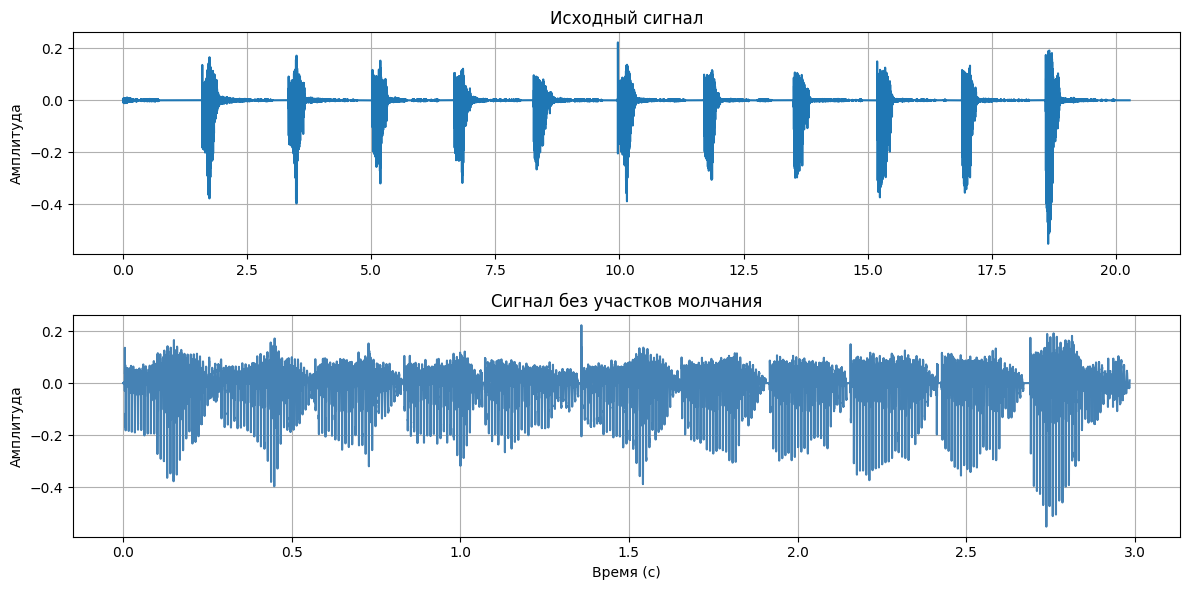

In [89]:
output_filename = "SOUNDS/sound_1_clear.wav"

voiced_signal = remove_silence_and_save(filename, output_filename, frame_duration=0.03, overlap=0.5)

# Визуализация до и после
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(np.arange(len(audio_signal))/fs, audio_signal)
plt.title("Исходный сигнал")
plt.ylabel("Амплитуда")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(np.arange(len(voiced_signal))/fs, voiced_signal, color='steelblue')
plt.title("Сигнал без участков молчания")
plt.xlabel("Время (с)")
plt.ylabel("Амплитуда")
plt.grid(True)

plt.tight_layout()
plt.show()

Пункт 4 - Запись аудиофайла

In [94]:
import sounddevice as sd
import time

def record_audio_sounddevice(filename, sample_rate=22050):
    print("=== Простая запись аудио ===")
    print("Нажмите Enter для начала записи")
    print("Снова нажмите Enter для остановки записи")
    print("Нажмите Ctrl+C для отмены")
    
    input("Нажмите Enter чтобы начать запись...")
    
    print("ЗАПИСЬ НАЧАТА... говорите!")
    print("Нажмите Enter чтобы остановить запись")
    
    # Записываем аудио в реальном времени
    recording = []
    
    def callback(indata, frames, time, status):
        recording.append(indata.copy())
    
    with sd.InputStream(samplerate=sample_rate, channels=1, dtype='int16', callback=callback):
        input()  # Ждем нажатия Enter для остановки
    
    print("ЗАПИСЬ ОСТАНОВЛЕНА")
    
    # Сохраняем записанное аудио
    if recording:
        audio_data = np.vstack(recording)
        sf.write(filename, audio_data, sample_rate, subtype='PCM_16')
        print(f"Аудио сохранено в: {filename}")
        print(f"Длительность: {len(audio_data) / sample_rate:.2f} секунд")
    else:
        print("Запись пуста")

Информация о файле:
SOUNDS/0.wav
samplerate: 22050 Hz
channels: 1
duration: 14.838 s
format: WAV (Microsoft) [WAV]
subtype: Signed 16 bit PCM [PCM_16]

Базовая информация:
 - Частота дискретизации: 22050 Гц
 - Количество сэмплов: 327168
 - Длительность: 14.84 секунд
 - Диапазон значений: [-0.045, 0.049]


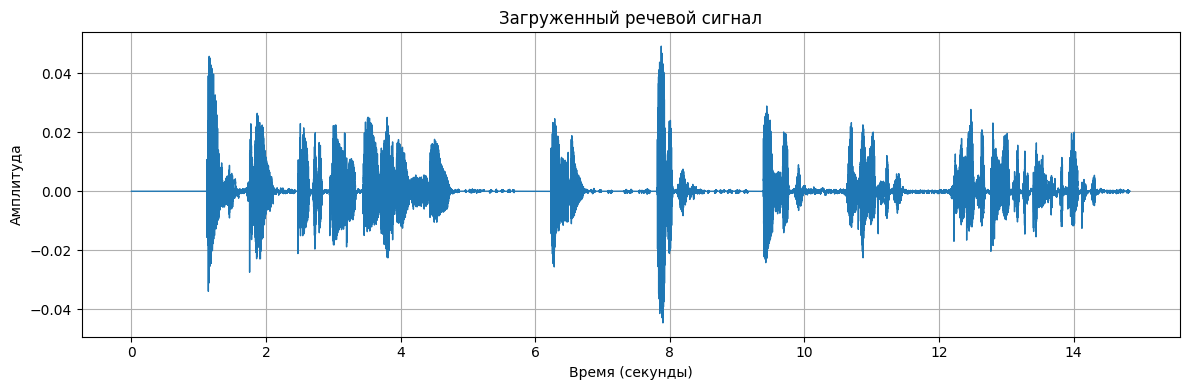

In [91]:
filename = "SOUNDS/0.wav"
# Информация о файле
print("Информация о файле:")
print(sf.info(filename))
print()
audio_signal, fs = load_audio_soundfile(filename)

# Вывод базовой информации
print("Базовая информация:")
print(f" - Частота дискретизации: {fs} Гц")
print(f" - Количество сэмплов: {len(audio_signal)}")
print(f" - Длительность: {len(audio_signal)/fs:.2f} секунд")
print(f" - Диапазон значений: [{np.min(audio_signal):.3f}, {np.max(audio_signal):.3f}]")

# Визуализация
plot_audio_signal(audio_signal, fs, "Загруженный речевой сигнал")

In [92]:
# output_filename = "SOUNDS/0.wav"
# record_audio_sounddevice(output_filename)

In [93]:
v = remove_silence_and_save("SOUNDS/0.wav", "SOUNDS/0_clear.wav", 0.03, 0.5)

Файл без тишины сохранён: SOUNDS/0_clear.wav
Исходная длительность: 14.84 с
После удаления тишины: 2.83 с
